In [180]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import re
import seaborn as sns

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn import metrics

In [2]:
data = pd.read_csv('countries_u.csv').drop(['Unnamed: 0', 'country_n'], axis=1)

In [3]:
data

,ISO3,Country / Territory,Year,Event Name,Date of event (start),Disaster Internal Displacements,Hazard Category,Hazard Type,Hazard Sub Type,koppen
0,AFG,Afghanistan,2017,Afghanistan: flood - Nimroz - 23/03/2017,2017-03-23T00:00:00Z,500,Weather related,Flood,Flood,22.0
1,AFG,Afghanistan,2017,Afghanistan: heavy rainfall and flood - Badakh...,2017-03-27T00:00:00Z,100,Weather related,Flood,Flood,62.0
2,AFG,Afghanistan,2017,Afghanistan: landslide - Ghazni - 04/03/2017,2017-03-04T00:00:00Z,7,Weather related,Wet Mass Movement,"Landslide, Avalanche",46.0
3,AFG,Afghanistan,2017,Afghanistan: avalanche - Bamyan - 23/02/2017,2017-03-23T00:00:00Z,7,Weather related,Flood,Flood,26.0
4,AFG,Afghanistan,2017,Afghanistan: avalanche - Daykundi - 03/02/2017,2017-02-03T00:00:00Z,200,Weather related,Wet Mass Movement,"Landslide, Avalanche",46.0
...,...,...,...,...,...,...,...,...,...,...
1818,BDI,Burundi,2021,Burundi: Strong Winds - Bujumbura Mairie - Mar...,2021-03-01T00:00:00Z,500,Weather related,Storm,Storm,14.0
1819,BDI,Burundi,2021,Burundi: Strong Winds - Kirundo - March 2021,2021-03-01T00:00:00Z,100,Weather related,Storm,Storm,14.0
1820,BDI,Burundi,2021,Burundi: Strong Winds - Cibitoke - March 2021,2021-03-01T00:00:00Z,200,Weather related,Storm,Storm,14.0
1821,BDI,Burundi,2021,Burundi: Strong Winds - Cankuzo - March 2021,2021-03-01T00:00:00Z,39,Weather related,Storm,Storm,14.0


## Exploring the Data

In [4]:
fake = data.loc[data['Disaster Internal Displacements'] <= 500]
data['Disaster Internal Displacements'].describe()

count    1.823000e+03
mean     2.056766e+04
std      1.452494e+05
min      1.000000e+00
25%      3.100000e+01
50%      2.000000e+02
75%      1.000000e+03
max      2.623000e+06
Name: Disaster Internal Displacements, dtype: float64

### Organizing the Data

sort displacements into 5 different categories 
- up to 25% of boxplot
- 25-50% of boxplot
- 50-75
- 75-100
- outliers

This will be done in order to run classification instead of regression analyses

In [5]:
#extracting month info 
date = list(data['Date of event (start)'])
month_list = list()

[month_list.append(int(day.split('-')[1])) for day in date]
    

data['month'] = month_list

In [6]:
#categorizing displacements
displacements = list(data['Disaster Internal Displacements'])
disp_cat_list = list()
IQR = 1.0*10**3 - 3.1*10
for disp in displacements:
    if(disp <= 3.1*10):
        disp_cat_list.append(1)
    elif(disp > 3.1*10 and disp <= 2.0*10**2):
        disp_cat_list.append(2)
    elif(disp > 2.0*10**2 and disp <= 1.0*10**3):
        disp_cat_list.append(3)
    elif(disp > 1.0*10**3 and disp <= (1.5*IQR)+1.0*10**3):
        disp_cat_list.append(4)
    else: #outliers
        disp_cat_list.append(5)
        
data['displacement_cat'] = disp_cat_list

In [7]:
data

,ISO3,Country / Territory,Year,Event Name,Date of event (start),Disaster Internal Displacements,Hazard Category,Hazard Type,Hazard Sub Type,koppen,month,displacement_cat
0,AFG,Afghanistan,2017,Afghanistan: flood - Nimroz - 23/03/2017,2017-03-23T00:00:00Z,500,Weather related,Flood,Flood,22.0,3,3
1,AFG,Afghanistan,2017,Afghanistan: heavy rainfall and flood - Badakh...,2017-03-27T00:00:00Z,100,Weather related,Flood,Flood,62.0,3,2
2,AFG,Afghanistan,2017,Afghanistan: landslide - Ghazni - 04/03/2017,2017-03-04T00:00:00Z,7,Weather related,Wet Mass Movement,"Landslide, Avalanche",46.0,3,1
3,AFG,Afghanistan,2017,Afghanistan: avalanche - Bamyan - 23/02/2017,2017-03-23T00:00:00Z,7,Weather related,Flood,Flood,26.0,3,1
4,AFG,Afghanistan,2017,Afghanistan: avalanche - Daykundi - 03/02/2017,2017-02-03T00:00:00Z,200,Weather related,Wet Mass Movement,"Landslide, Avalanche",46.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
1818,BDI,Burundi,2021,Burundi: Strong Winds - Bujumbura Mairie - Mar...,2021-03-01T00:00:00Z,500,Weather related,Storm,Storm,14.0,3,3
1819,BDI,Burundi,2021,Burundi: Strong Winds - Kirundo - March 2021,2021-03-01T00:00:00Z,100,Weather related,Storm,Storm,14.0,3,2
1820,BDI,Burundi,2021,Burundi: Strong Winds - Cibitoke - March 2021,2021-03-01T00:00:00Z,200,Weather related,Storm,Storm,14.0,3,2
1821,BDI,Burundi,2021,Burundi: Strong Winds - Cankuzo - March 2021,2021-03-01T00:00:00Z,39,Weather related,Storm,Storm,14.0,3,2


### Graphing the Data

- month distribution
- koppen distribution

pivot table versus displacements -> graphing


- month v displacements 
- koppen v displacements (scatter)
- year v displacements 
- hazard type v displacements (histogram)





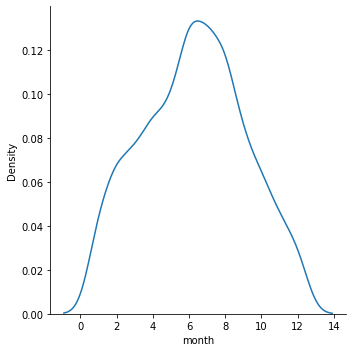

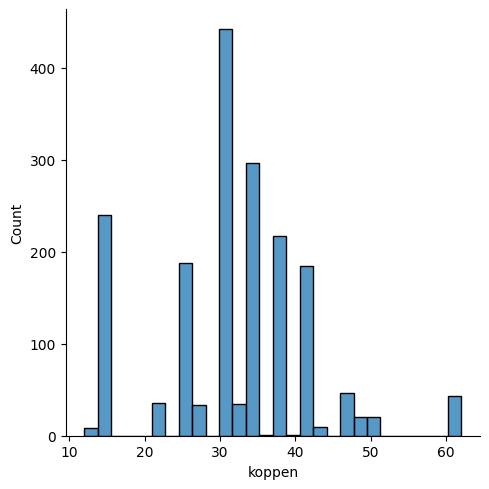

In [8]:
sns.displot(data, x="month", kind ='kde')
sns.displot(data, x="koppen")

<AxesSubplot:xlabel='Disaster Internal Displacements', ylabel='koppen'>

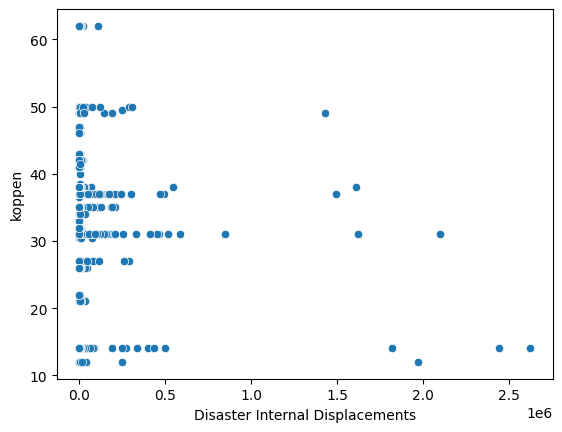

In [9]:
sns.scatterplot(data=data, x="Disaster Internal Displacements", y="koppen")

In [10]:
#transforming hazard type
le = LabelEncoder()
data['haz_t_cat'] = le.fit_transform(data['Hazard Type'])
data

,ISO3,Country / Territory,Year,Event Name,Date of event (start),Disaster Internal Displacements,Hazard Category,Hazard Type,Hazard Sub Type,koppen,month,displacement_cat,haz_t_cat
0,AFG,Afghanistan,2017,Afghanistan: flood - Nimroz - 23/03/2017,2017-03-23T00:00:00Z,500,Weather related,Flood,Flood,22.0,3,3,4
1,AFG,Afghanistan,2017,Afghanistan: heavy rainfall and flood - Badakh...,2017-03-27T00:00:00Z,100,Weather related,Flood,Flood,62.0,3,2,4
2,AFG,Afghanistan,2017,Afghanistan: landslide - Ghazni - 04/03/2017,2017-03-04T00:00:00Z,7,Weather related,Wet Mass Movement,"Landslide, Avalanche",46.0,3,1,8
3,AFG,Afghanistan,2017,Afghanistan: avalanche - Bamyan - 23/02/2017,2017-03-23T00:00:00Z,7,Weather related,Flood,Flood,26.0,3,1,4
4,AFG,Afghanistan,2017,Afghanistan: avalanche - Daykundi - 03/02/2017,2017-02-03T00:00:00Z,200,Weather related,Wet Mass Movement,"Landslide, Avalanche",46.0,2,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818,BDI,Burundi,2021,Burundi: Strong Winds - Bujumbura Mairie - Mar...,2021-03-01T00:00:00Z,500,Weather related,Storm,Storm,14.0,3,3,6
1819,BDI,Burundi,2021,Burundi: Strong Winds - Kirundo - March 2021,2021-03-01T00:00:00Z,100,Weather related,Storm,Storm,14.0,3,2,6
1820,BDI,Burundi,2021,Burundi: Strong Winds - Cibitoke - March 2021,2021-03-01T00:00:00Z,200,Weather related,Storm,Storm,14.0,3,2,6
1821,BDI,Burundi,2021,Burundi: Strong Winds - Cankuzo - March 2021,2021-03-01T00:00:00Z,39,Weather related,Storm,Storm,14.0,3,2,6


In [11]:
data.loc[data['koppen']%2==0]

,ISO3,Country / Territory,Year,Event Name,Date of event (start),Disaster Internal Displacements,Hazard Category,Hazard Type,Hazard Sub Type,koppen,month,displacement_cat,haz_t_cat
0,AFG,Afghanistan,2017,Afghanistan: flood - Nimroz - 23/03/2017,2017-03-23T00:00:00Z,500,Weather related,Flood,Flood,22.0,3,3,4
1,AFG,Afghanistan,2017,Afghanistan: heavy rainfall and flood - Badakh...,2017-03-27T00:00:00Z,100,Weather related,Flood,Flood,62.0,3,2,4
2,AFG,Afghanistan,2017,Afghanistan: landslide - Ghazni - 04/03/2017,2017-03-04T00:00:00Z,7,Weather related,Wet Mass Movement,"Landslide, Avalanche",46.0,3,1,8
3,AFG,Afghanistan,2017,Afghanistan: avalanche - Bamyan - 23/02/2017,2017-03-23T00:00:00Z,7,Weather related,Flood,Flood,26.0,3,1,4
4,AFG,Afghanistan,2017,Afghanistan: avalanche - Daykundi - 03/02/2017,2017-02-03T00:00:00Z,200,Weather related,Wet Mass Movement,"Landslide, Avalanche",46.0,2,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818,BDI,Burundi,2021,Burundi: Strong Winds - Bujumbura Mairie - Mar...,2021-03-01T00:00:00Z,500,Weather related,Storm,Storm,14.0,3,3,6
1819,BDI,Burundi,2021,Burundi: Strong Winds - Kirundo - March 2021,2021-03-01T00:00:00Z,100,Weather related,Storm,Storm,14.0,3,2,6
1820,BDI,Burundi,2021,Burundi: Strong Winds - Cibitoke - March 2021,2021-03-01T00:00:00Z,200,Weather related,Storm,Storm,14.0,3,2,6
1821,BDI,Burundi,2021,Burundi: Strong Winds - Cankuzo - March 2021,2021-03-01T00:00:00Z,39,Weather related,Storm,Storm,14.0,3,2,6


In [12]:
pd.Series(list(data['haz_t_cat'])).value_counts()

4     718
6     507
9     371
8     117
2      45
3      36
1      18
0       7
5       2
10      1
7       1
dtype: int64

In [13]:
(pd.Series(list(data['koppen'])).value_counts())

31.0    436
35.0    263
14.0    240
26.0    188
37.0    159
42.0    134
38.0     55
41.0     50
62.0     43
34.0     33
27.0     33
32.0     30
46.0     30
21.0     27
49.0     20
50.0     18
47.0     17
22.0      9
43.0      9
12.0      8
30.5      6
33.0      5
37.5      2
49.5      2
38.5      1
42.5      1
36.5      1
40.0      1
34.5      1
41.5      1
dtype: int64

In [97]:
data = data.assign(koppen = lambda x: x['koppen']*10)
data

,ISO3,Country / Territory,Year,Event Name,Date of event (start),Disaster Internal Displacements,Hazard Category,Hazard Type,Hazard Sub Type,koppen,month,displacement_cat,haz_t_cat
0,AFG,Afghanistan,2017,Afghanistan: flood - Nimroz - 23/03/2017,2017-03-23T00:00:00Z,500,Weather related,Flood,Flood,220.0,3,3,4
1,AFG,Afghanistan,2017,Afghanistan: heavy rainfall and flood - Badakh...,2017-03-27T00:00:00Z,100,Weather related,Flood,Flood,620.0,3,2,4
2,AFG,Afghanistan,2017,Afghanistan: landslide - Ghazni - 04/03/2017,2017-03-04T00:00:00Z,7,Weather related,Wet Mass Movement,"Landslide, Avalanche",460.0,3,1,8
3,AFG,Afghanistan,2017,Afghanistan: avalanche - Bamyan - 23/02/2017,2017-03-23T00:00:00Z,7,Weather related,Flood,Flood,260.0,3,1,4
4,AFG,Afghanistan,2017,Afghanistan: avalanche - Daykundi - 03/02/2017,2017-02-03T00:00:00Z,200,Weather related,Wet Mass Movement,"Landslide, Avalanche",460.0,2,2,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1818,BDI,Burundi,2021,Burundi: Strong Winds - Bujumbura Mairie - Mar...,2021-03-01T00:00:00Z,500,Weather related,Storm,Storm,140.0,3,3,6
1819,BDI,Burundi,2021,Burundi: Strong Winds - Kirundo - March 2021,2021-03-01T00:00:00Z,100,Weather related,Storm,Storm,140.0,3,2,6
1820,BDI,Burundi,2021,Burundi: Strong Winds - Cibitoke - March 2021,2021-03-01T00:00:00Z,200,Weather related,Storm,Storm,140.0,3,2,6
1821,BDI,Burundi,2021,Burundi: Strong Winds - Cankuzo - March 2021,2021-03-01T00:00:00Z,39,Weather related,Storm,Storm,140.0,3,2,6


In [98]:
X = data[['koppen', 'Year', 'month', 'haz_t_cat']]
y = data['displacement_cat']
train_x,test_x,train_y,test_y = train_test_split(X, y, test_size=0.30, random_state=42)

In [99]:
train_x

,koppen,Year,month,haz_t_cat
1116,140.0,2020,6,4
711,310.0,2020,4,6
1403,380.0,2018,9,6
759,260.0,2020,11,9
118,220.0,2019,2,4
...,...,...,...,...
1130,140.0,2020,11,6
1294,500.0,2017,7,4
860,350.0,2020,7,9
1459,490.0,2019,4,9


## Modeling Data

In [153]:
class my_model:
    def __init__(self, train_x, train_y, test_x, test_y, lower, middle, upper):
        self.train_x = train_x
        self.train_y = train_y
        self.test_x = test_x
        self.test_y = test_y
        self.lower = lower
        self.middle = middle
        self.upper = upper
        self.avg = 0
        
             
    def cat(self, string):
        if(string == 'haz_t_cat'):
            return 2
        if(string == 'month'):
            return 2
        if(string == 'koppen'):
            return 3
        if (string == 'Year'):
            return 4
        else:
            print("ERRRORRRR")
    
    def fit(self):
        #main thing is making self.label_dict
        self.train_x = self.train_x.assign(Label = lambda x: x[self.lower]+
                                         (self.cat(self.lower))*x[self.middle]+
                                         (self.cat(self.middle) + self.cat(self.lower))*x[self.upper]) 
        
        label_list = list(pd.Series(self.train_x.Label).value_counts().to_dict().keys())
        
        self.label_dict = dict()
        for label in label_list:
            x = list(self.train_y[list(self.train_x.loc[self.train_x['Label'] == label].index)])
            if x.count(max(x, key=x.count))/len(x) >= 0.5:
                self.label_dict[int(label)] = max(x, key=x.count)
            else:
                self.label_dict[int(label)] = round(sum(x)/len(x))
                

    def transform (self):
        self.test_x = self.test_x.assign(Label = lambda x: x[self.lower]+
                                         (self.cat(self.lower))*x[self.middle]+
                                         (self.cat(self.middle) + self.cat(self.lower))*x[self.upper])
        #change multipliers

        # sorting labels
        x = list(self.label_dict.keys())
        x.sort()

        label_list = list(self.test_x['Label'])
        est_lst = list()
        for label in label_list:
            try: 
                est_lst.append(self.label_dict[label])
            except:
                est_lst.append(self.label_dict[lin_search(label, x)])

        self.test_x['estimate'] = est_lst


        #finding test_x['actual']
        self.test_x['actual'] = self.test_y
        self.test_x = self.test_x.assign(diff = lambda x: x['estimate']-x['actual'])
        diff_lst = list(self.test_x['diff'])
        self.avg = sum(diff_lst)/len(diff_lst)

        return len(self.test_x.loc[self.test_x['diff'] == 0])/len(self.test_x)
    
#     def avg (self):
#         return self.avg

In [169]:
# print('haz_t_cat', 'month', 'koppen')
# x = my_model(train_x, train_y, test_x, test_y, 'haz_t_cat', 'month', 'koppen')
# x.fit()
# print(x.transform())

# print('haz_t_cat', 'koppen', 'month')
# x = my_model(train_x, train_y, test_x, test_y, 'haz_t_cat', 'koppen', 'month')
# x.fit()
# print(x.transform())

al = list()
tl = list()

print('koppen', 'haz_t_cat', 'month')
x = my_model(train_x, train_y, test_x, test_y, 'koppen', 'haz_t_cat', 'month')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)


print('koppen', 'month', 'haz_t_cat')
x = my_model(train_x, train_y, test_x, test_y, 'koppen', 'month', 'haz_t_cat')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

print('month', 'koppen', 'haz_t_cat')
x = my_model(train_x, train_y, test_x, test_y, 'month', 'koppen', 'haz_t_cat')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

print('month', 'haz_t_cat', 'koppen')
x = my_model(train_x, train_y, test_x, test_y, 'month', 'haz_t_cat', 'koppen')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

print('Year', 'haz_t_cat', 'koppen')
x = my_model(train_x, train_y, test_x, test_y, 'Year', 'haz_t_cat', 'koppen')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

# print('Year', 'month', 'haz_t_cat')
# x = my_model(train_x, train_y, test_x, test_y, 'Year', 'month', 'haz_t_cat')
# x.fit()
# print(x.transform())

print('Year', 'koppen', 'haz_t_cat')
x = my_model(train_x, train_y, test_x, test_y, 'Year', 'koppen', 'haz_t_cat')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

print('Year', 'haz_t_cat', 'koppen')
x = my_model(train_x, train_y, test_x, test_y, 'Year', 'haz_t_cat', 'koppen')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

print('haz_t_cat', 'Year', 'koppen')
x = my_model(train_x, train_y, test_x, test_y, 'haz_t_cat', 'Year', 'koppen')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

print('haz_t_cat', 'koppen', 'Year')
x = my_model(train_x, train_y, test_x, test_y, 'haz_t_cat', 'koppen', 'Year')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

print('koppen', 'haz_t_cat', 'Year')
x = my_model(train_x, train_y, test_x, test_y, 'koppen', 'haz_t_cat', 'Year')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

print('koppen', 'Year', 'haz_t_cat')
x = my_model(train_x, train_y, test_x, test_y, 'koppen', 'Year', 'haz_t_cat')
x.fit()
t = x.transform()
a = x.avg
print(t)
print(a)
tl.append(t)
al.append(a)

# print('haz_t_cat', 'month', 'Year')
# x = my_model(train_x, train_y, test_x, test_y, 'haz_t_cat', 'month', 'Year')
# x.fit()

print('\n')
print(max(tl))

al = [abs(ele) for ele in al]
min(al)

koppen haz_t_cat month
0.29250457038391225
0.012797074954296161
koppen month haz_t_cat
0.28153564899451555
0.003656307129798903
month koppen haz_t_cat
0.28153564899451555
0.029250457038391225
month haz_t_cat koppen
0.2961608775137112
0.05301645338208409
Year haz_t_cat koppen
0.3235831809872029
-0.07861060329067641
Year koppen haz_t_cat
0.3272394881170018
-0.03290676416819013
Year haz_t_cat koppen
0.3235831809872029
-0.07861060329067641
haz_t_cat Year koppen
0.2979890310786106
-0.031078610603290677
haz_t_cat koppen Year
0.31992687385740404
-0.031078610603290677
koppen haz_t_cat Year
0.2961608775137112
-0.14076782449725778
koppen Year haz_t_cat
0.30895795246800734
-0.05850091407678245


0.3272394881170018


0.003656307129798903

The best arrangement of variables in terms of accuracy was: **1) koppen 2) hazard category 3) year**  <br>
The best arrangement of variables in terms of mean was: **1) hazard category 2) month 3) koppen**



## Using Other Methods for Prediction

### Decision Tree Classification

In [177]:
X = data[['koppen', 'Year', 'month', 'haz_t_cat']]
y = data['displacement_cat']
train_x,test_x,train_y,test_y = train_test_split(X, y, test_size=0.30, random_state=42)

model_dtc = DecisionTreeClassifier()
model_dtc = model_dtc.fit(train_x,train_y)
scores = cross_val_score(model_dtc, test_x, test_y)
scores.mean()

0.32897414512093415

### Random Forest Classification

In [185]:
model_rfc = RandomForestClassifier()
model_rfc = model_rfc.fit(train_x,train_y)
scores = cross_val_score(model_rfc, test_x, test_y)
scores.mean()

0.33454545454545453

### XGBoost Classification

In [186]:
le = LabelEncoder()
train_y = le.fit_transform(train_y)
test_y = le.fit_transform(test_y)

model_xgb = XGBClassifier()
model_xgb = model_xgb.fit(train_x,train_y)
scores = cross_val_score(model_xgb, test_x, test_y)
scores.mean()

0.3234695579649708

### GradientBoostingClassifier 

In [187]:
X = data[['koppen', 'Year', 'month', 'haz_t_cat']]
y = data['displacement_cat']
train_x,test_x,train_y,test_y = train_test_split(X, y, test_size=0.30, random_state=42)

model_gbc = GradientBoostingClassifier()
model_gbc = model_gbc.fit(train_x,train_y)
scores = cross_val_score(model_gbc, test_x, test_y)
scores.mean()

0.35644703919933274

Out of the other methods of prediction, the Gradient Boosting Classifier is better having a mean accuracy above the XGBoost Classifier, the Random Forest Tree Classifier and the Decision Tree classifier. Additionally, this score is above the best score attained from the basic model created above this section. Overall, because these values are relatively low, more data should be attained in order to increase the scores of these models. 